In [1]:
import torch
import numpy as np
import pickle

In [2]:
def generate_property():
    # each node contain such property:
    #          E/I, blocked_in_stat, I_extern_Input, sub_block_idx, C, T_ref, g_Li, V_L, V_th, V_reset, g_ui, V_ui, tao_ui
    #   size:  1,   1,               1,                1,           1, 1,     1,    1,   1,    1,       4     4,    4
    #   dtype: b,   b,               f,                i,           f, f,     f,    f,   f,    f,       f,    f,    f
    # b means bool(although storage as float), f means float.

    property = np.zeros([1, 22], dtype=np.float32)
    
    E_thresh = 1
    
    property[:, 0] = 1

    property[:, 1] = 0

    property[:, 2] = 0

    property[:, 3] = 0
    property[:, 4] = 1
    property[:, 5] = 5
    property[:, 6] = 0.001
    property[:, 7] = -75
    property[:, 8] = -50
    property[:, 9] = -65

    g_ui =np.array([5/275, 5/4000, 3/30, 3/730])
    g_ui =g_ui if isinstance(g_ui, np.ndarray) else np.array(g_ui)
    property[:, 10:14] = g_ui
    
    V_ui = np.array([0, 0, -70, -100])
    V_ui =  V_ui  if isinstance(V_ui, np.ndarray) else np.array(V_ui)
    property[:, 14:18] = V_ui
    
    tao_ui =np.array ([2, 40, 10, 50])
    tao_ui = tao_ui if isinstance(tao_ui, np.ndarray) else np.array(tao_ui)

    property[:, 18:22] = tao_ui
    

    return property

In [55]:
class block:
    def __init__(self, node_property, delta_t=1):
        # A block is a set of spliking neurals with inner full connections, we consider 4 connections:
        # AMPA, NMDA, GABAa and GABAb
        # shape note:
        #
        # N: numbers of neural cells
        # K: connections kind, = 4 (AMPA, NMDA, GABAa and GABAb)
        
        import torch
        
        N = 1
        K = 4
        
        self.delta_t = delta_t
        
        self.I_extern_Input = torch.tensor(node_property[:, 2]) # extern_input index , shape[K]
        self.V_ui =torch.tensor(node_property[:, 14:18].reshape([4,1]))  # AMPA, NMDA, GABAa and GABAb potential, shape [K, N]
        self.tau_ui = torch.tensor(node_property[:, 18:22].reshape([4,1]))# shape [K, N]
        self.g_ui = torch.tensor(node_property[:, 10:14].reshape([4,1])) # shape [K, N]
        self.g_Li = torch.tensor(node_property[:, 6])  # shape [N]
        self.V_L = torch.tensor(node_property[:, 7])  # shape [N]
        self.C = torch.tensor(node_property[:, 4])   # shape [N]
        self.sub_idx = torch.tensor(node_property[:, 3]) # shape [N]
        self.V_th = torch.tensor(node_property[:, 8])  # shape [N]
        self.V_reset = torch.tensor(node_property[:, 9]) # shape [N]
        self.T_ref = torch.tensor(node_property[:, 5]) # shape [N]

        self.t_ik_last = torch.zeros([N]) # shape [N]
        self.active = torch.tensor(False) # bool
        self.V_i = torch.ones([N]) * (self.V_th + self.V_reset)/2  # membrane potential, shape: [N]
        self.J_ui = torch.zeros([K, N])  # shape [K, N]
        self.t = torch.tensor(0.)  # scalar

    def update_J_ui(self, spikes):
        # spikes: num of spike
        
        J_ui_activate_part = torch.ones(4,1) * spikes
        self.J_ui = self.J_ui * torch.exp(-self.delta_t / self.tau_ui)
        self.J_ui += J_ui_activate_part
#         print(f'J_ui: {self.J_ui}')

    def update_I_syn(self):
        self.I_ui = self.g_ui * (self.V_ui - self.V_i) * self.J_ui
        self.I_syn = self.I_ui.sum(dim=0)
#         print(f'I_syn: {self.I_syn}')
        
    def update_t_ik_last(self):
#         print(f't_ik_last: {self.t_ik_last}')
        self.t_ik_last = torch.where(self.active, self.t, self.t_ik_last)
#         print(f't_ik_last after: {self.t_ik_last}')

    def update_Vi(self):
        
        delta_Vi = -self.g_Li * (self.V_i - self.V_L) + self.I_syn + self.I_extern_Input
        delta_Vi *= self.delta_t / self.C
        Vi_normal = self.V_i + delta_Vi
#         print(f'Vi_normal: {Vi_normal}')

        is_not_saturated = (self.t >= self.t_ik_last + self.T_ref)
#         print(f'is_not_saturated: {is_not_saturated}')
        self.V_i = torch.where(is_not_saturated, Vi_normal, self.V_reset)
#         print(f'V_i: {self.V_i}')
        self.active = self.V_i >= self.V_th
#         print(f'active: {self.active}')
        self.V_i = torch.min(self.V_i, self.V_th)
#         print(f'V_th: {self.V_th}')

    def update(self, spikes):
        self.t += self.delta_t
        
        self.update_J_ui(spikes)
        self.update_I_syn()
        self.update_t_ik_last()
        self.update_Vi()

        return self.t.tolist(), self.V_i.tolist()[0]

In [56]:
t = 1000 #ms
sp = torch.poisson(torch.ones(t))
pro = generate_property()
b = block(pro)

In [57]:
x_out = []
y_out = []
for i in range(t):
    x, y = b.update(sp[i])
    x_out.append(x)
    y_out.append(y)

In [58]:
import matplotlib.pyplot as plt

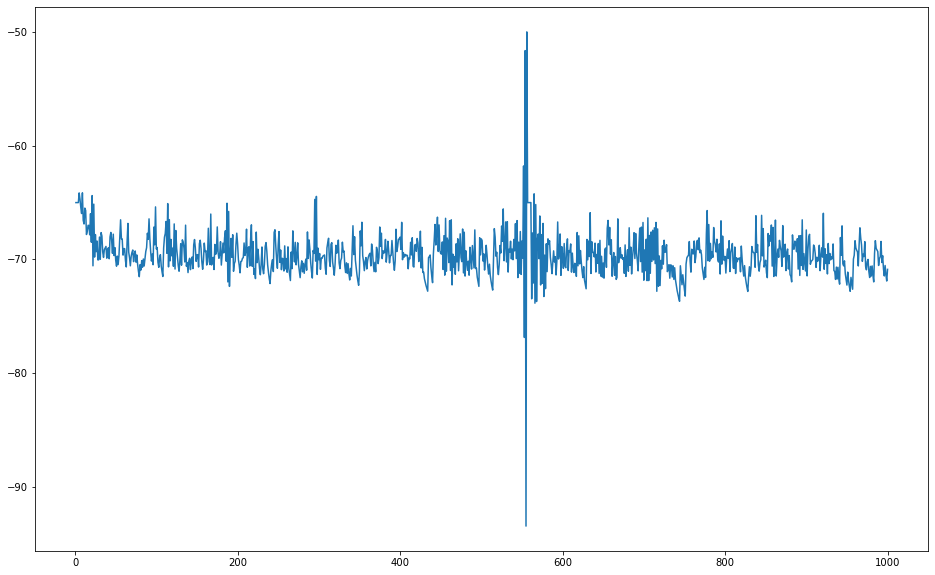

In [59]:
plt.subplots(figsize=(16, 10))
plt.plot(x_out,y_out)  #画图
plt.show()#loss函数图